In [72]:
import torch
import torch.nn as nn
from torchvision import models, datasets
from recycling_app.preprocessing.preprocessing import Preprocessor
import os
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
random_seed = 125

In [6]:
prepocessor = Preprocessor()

In [8]:
dataset_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw")
dataset = datasets.ImageFolder(dataset_path, transform=prepocessor.transform)

In [9]:
print(f"Labels: {dataset.classes}")

Labels: ['cardboard', 'food_organics', 'glass', 'metal', 'paper', 'plastic', 'textile', 'trash', 'vegetation']


In [10]:
test_size = int(0.2 * len(dataset))
train_val_size = len(dataset) - test_size
train_size = int(0.8 * train_val_size)
val_size = train_val_size - train_size

In [11]:
train_val_dataset, test_dataset = torch.utils.data.random_split(
    dataset,
    [train_val_size, test_size],
    generator=torch.Generator().manual_seed(random_seed)
)

In [12]:
train_dataset, val_dataset = torch.utils.data.random_split(
    train_val_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(random_seed)
)

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])
resnet50.to(device)
resnet50.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [19]:
def extract_features(data_loader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Extracting features", unit="batch"):
            inputs = inputs.to(device)
            output = model(inputs).squeeze()
            features.append(output.cpu().numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

In [47]:
train_features, train_labels = extract_features(train_loader, resnet50, device)

Extracting features: 100%|██████████| 292/292 [06:07<00:00,  1.26s/batch]


In [48]:
val_features, val_labels = extract_features(val_loader, resnet50, device)

Extracting features: 100%|██████████| 73/73 [01:29<00:00,  1.23s/batch]


In [49]:
train_features1 = train_features.reshape(train_features.shape[0], -1)
val_features1 = val_features.reshape(val_features.shape[0], -1)

train_features1 = torch.tensor(train_features, dtype=torch.float32)
val_features1 = torch.tensor(val_features, dtype=torch.float32)

train_labels1 = torch.tensor(train_labels, dtype=torch.long)
val_labels1 = torch.tensor(val_labels, dtype=torch.long)

In [62]:
clf = SGDClassifier(penalty="elasticnet")

In [63]:
clf.fit(train_features1, train_labels1)

SGDClassifier(penalty='elasticnet')

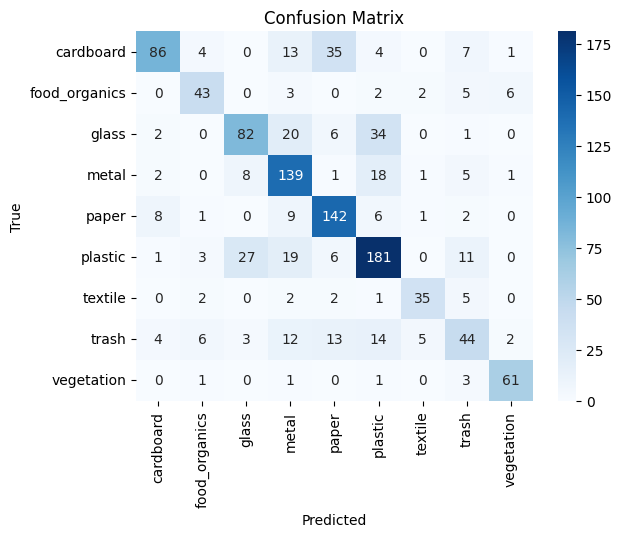

In [64]:
y_pred = clf.predict(val_features)

cm = confusion_matrix(val_labels, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [65]:
report = classification_report(val_labels, y_pred, target_names=dataset.classes)
print(report)

               precision    recall  f1-score   support

    cardboard       0.83      0.57      0.68       150
food_organics       0.72      0.70      0.71        61
        glass       0.68      0.57      0.62       145
        metal       0.64      0.79      0.71       175
        paper       0.69      0.84      0.76       169
      plastic       0.69      0.73      0.71       248
      textile       0.80      0.74      0.77        47
        trash       0.53      0.43      0.47       103
   vegetation       0.86      0.91      0.88        67

     accuracy                           0.70      1165
    macro avg       0.72      0.70      0.70      1165
 weighted avg       0.70      0.70      0.69      1165



In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=random_seed)

In [75]:
forest_clf.fit(train_features1, train_labels1)

RandomForestClassifier(random_state=125)

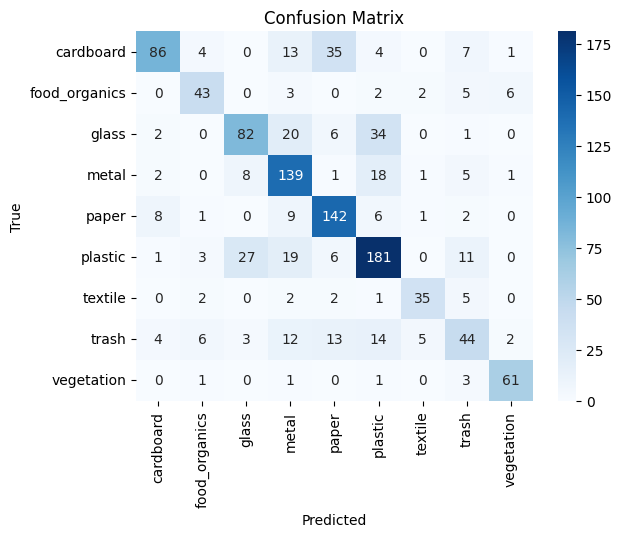

In [76]:
y_pred_forest = forest_clf.predict(val_features)

cm = confusion_matrix(val_labels, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [77]:
report = classification_report(val_labels, y_pred_forest, target_names=dataset.classes)
print(report)

               precision    recall  f1-score   support

    cardboard       0.74      0.55      0.63       150
food_organics       0.71      0.85      0.78        61
        glass       0.71      0.53      0.61       145
        metal       0.60      0.78      0.68       175
        paper       0.61      0.80      0.69       169
      plastic       0.63      0.71      0.67       248
      textile       0.82      0.49      0.61        47
        trash       0.53      0.23      0.32       103
   vegetation       0.84      0.91      0.87        67

     accuracy                           0.66      1165
    macro avg       0.69      0.65      0.65      1165
 weighted avg       0.66      0.66      0.65      1165

